## Data Cleaning and Preprocessing

In [257]:
import pandas as pd
import numpy as np
import re
from word2number import w2n
import matplotlib.pyplot as plt
from datetime import datetime

In [258]:
df = pd.read_csv('census.csv')
df.head()

,first_name,last_name,address,local_number,salary,employer,member_id,start_date,actively_working
0,Paul,Black,384 Willow St,103,46467,DEF Ltd,1001,2019-03-22,False
1,Alice,Lee,178 Fir St,105,46330,DEF Ltd,1002,2019-01-01,False
2,Victor,Evans,797 Maple St,101,45217,XYZ Inc,1003,2017-08-28,True
3,Mia,Davis,455 Maple St,103,51197,DEF Ltd,1004,2018-01-21,False
4,Frank,Edwards,354 Maple St,105,58269,DEF Ltd,1005,2019-10-29,True


### Duplicates

In [259]:
# Shows how many duplicates are in the data
df['member_id'].drop_duplicates().shape, df['member_id'].shape

((47705,), (50000,))

In [260]:
# Example of duplicate found for member_id "12748"
df[df['member_id'] == 12748]

,first_name,last_name,address,local_number,salary,employer,member_id,start_date,actively_working
11747,Jack,Davis,817 Fir St,105,46206,DEF Ltd,12748,2018-12-12,True
49968,Jane,Mitchell,492 Poplar St,101,fifty thousand,DEF Ltd,12748,2018-06-18,True


In [261]:
# Drop duplicate member_id's
df = df.drop_duplicates(subset='member_id', keep='first')

In [262]:
# Confirm there are no duplicates
duplicate_df = df[df.duplicated(subset=['member_id'], keep=False)]
duplicate_df.sort_values(by='member_id').head(6)

,first_name,last_name,address,local_number,salary,employer,member_id,start_date,actively_working


### Salary Preprocessingg

#### There were salaries written as text i.e. "fifty-thousand", mixed in numbers in text format. This Function converts any written numbers to actual numbers and changes entire column to numeric format.

In [263]:
# Function to convert mixed data types in salary column to numeric values
def convert_written_to_number(text):
    try:
        # Check if text is numeric
        if pd.notna(text) and re.match(r'^-?\d+(?:,\d+)?(?:\.\d+)?$', text.strip()):
            return float(text.replace(',', ''))  # Convert numeric text to float

        # Convert written numbers to actual numbers using word2number library
        return w2n.word_to_num(text) if text != 'NaN' else None
    
    except ValueError:
        return text  # Return original text if conversion fails

# Convert mixed numbers and written numbers to actual numbers in 'values' column
df['salary'] = df['salary'].apply(convert_written_to_number)

#### There is a discrepancy with the salary "50,000". The graph below indicates the recurring value "50,000" could have been entered as a default placeholder where salary was unknown. See graph below.

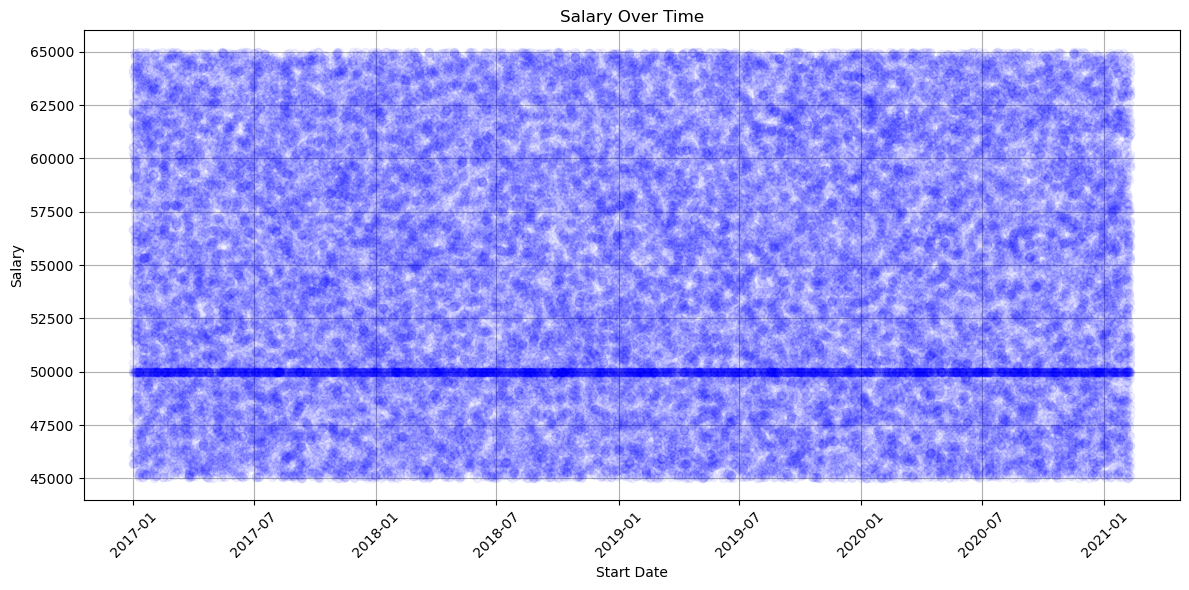

In [264]:
# Scatter plot of salaries over time
df['start_date'] = pd.to_datetime(df['start_date'])
dates = df.sort_values('start_date')
plt.figure(figsize=(12, 6))
plt.plot(dates['start_date'], dates['salary'], marker='o', linestyle='-', color='b', alpha=.05)
plt.title('Salary Over Time')
plt.xlabel('Start Date')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show();

In [265]:
# Get count of potential salary entry errors
placeholder_salaries = df[df['salary'] == 50000]
placeholder_count = placeholder_salaries.shape[0]
print(f"{placeholder_count} of {df.shape[0]} salary entries are $50,000.")

2363 of 47705 salary entries are $50,000.


In [266]:
# There are 2,363 salaries showing as '$50,000'. This entry count is drastic in comparison to other salary counts.
df['salary'].value_counts().sort_values(ascending=False).head(15)

salary
50000.0    2363
49788.0      10
64229.0      10
62217.0       9
52999.0       9
62159.0       9
55403.0       9
46741.0       9
45735.0       9
45779.0       8
55564.0       8
54391.0       8
48761.0       8
52652.0       8
55145.0       8
Name: count, dtype: int64

In [267]:
# Remove placeholder salaries to avoid skewed statistics in salary analysis. 
# NOTE: If these records were to be preserved, the incorrect entries would have to be replaced with the mean salary of entire dataset to conduct analysis.
df = df[df['salary'] != 50000]

### Nulls

In [268]:
# All missing values from highest to lowest
df.isnull().sum().sort_values(ascending=False).head(20)

first_name          2383
last_name              0
address                0
local_number           0
salary                 0
employer               0
member_id              0
start_date             0
actively_working       0
dtype: int64

In [269]:
# Fills missing first names with placeholder 'firstname'
df['first_name'] = df['first_name'].fillna('first_name')

In [270]:
# Confirm there are no nulls before exporting
df.isnull().sum()

first_name          0
last_name           0
address             0
local_number        0
salary              0
employer            0
member_id           0
start_date          0
actively_working    0
dtype: int64

In [271]:
# Convert 'start_date' column to datetime format for time series analysis
df['start_date'] = pd.to_datetime(df['start_date'])

### Feature Engineering: Column created as length of active employment

In [272]:
# Create a column showing length of years worked
current_date = pd.to_datetime(datetime.now())
df['length_worked_yrs'] = (current_date - df['start_date']).dt.days / 365.25  # Converts days to years

# Handle cases where 'start_date' might be NaT (Not a Time)
df['length_worked_yrs'] = df['length_worked_yrs'].fillna(0)
df['length_worked_yrs'].head(3)

0    5.229295
1    5.448323
2    6.792608
Name: length_worked_yrs, dtype: float64

In [273]:
# Confirm start_date is in the datetime format.('M8[ns]' is acceptable datetime format)
df['start_date'].dtype

dtype('<M8[ns]')

In [274]:
# set member_id as index for future analysis and QUERIES
df.set_index('member_id', inplace=True)

In [275]:
# Save cleaned CSV
df.to_csv('cleaned_census.csv', index=True)